   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
<class 'pandas.core.f

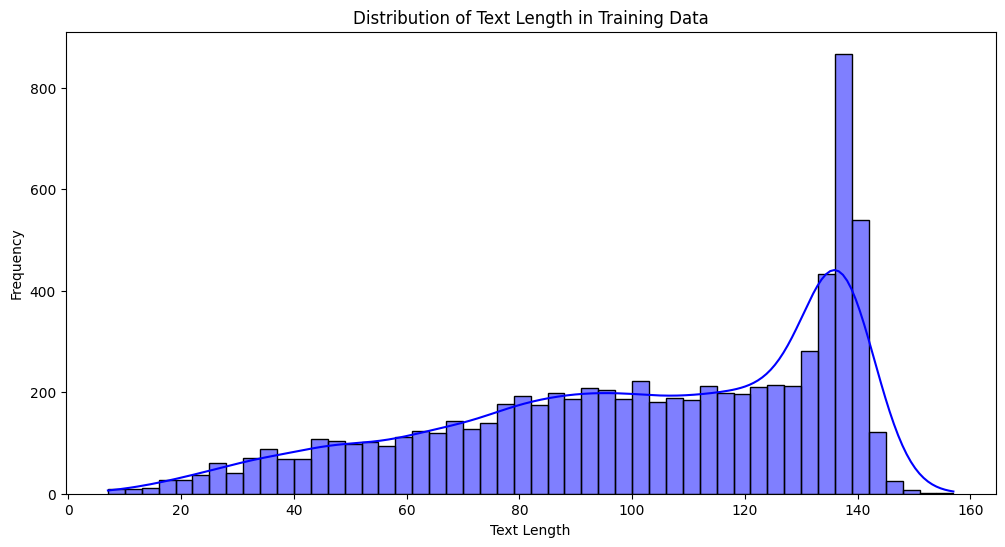

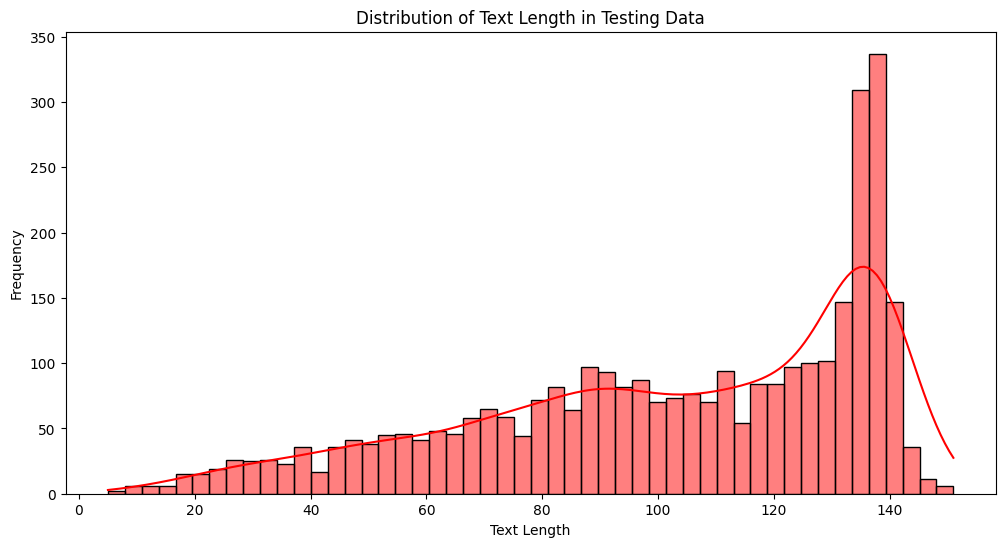

NaN values in training data:
id             0
keyword        0
location       0
text           0
target         0
text_length    0
dtype: int64
NaN values in testing data:
id             0
keyword        0
location       0
text           0
text_length    0
dtype: int64


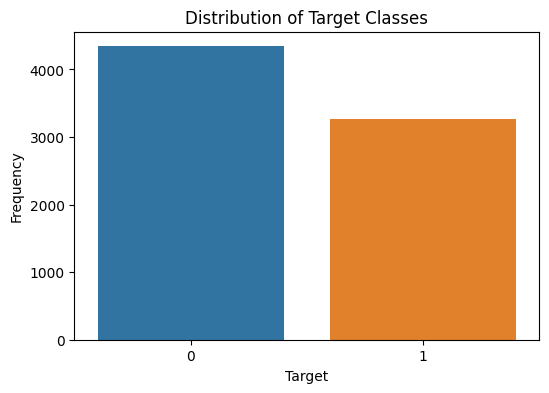

Logistic Regression:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.84      0.67      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.81      0.80      1523



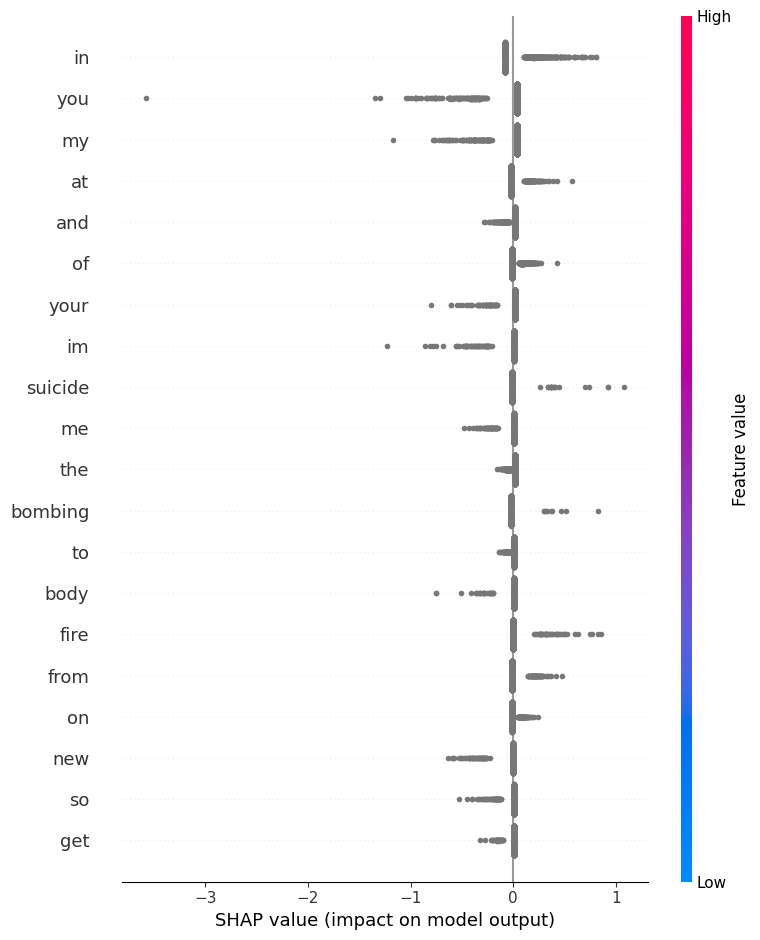

Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83       874
           1       0.84      0.59      0.70       649

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.76      1523
weighted avg       0.79      0.78      0.77      1523

Naive Bayes:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       874
           1       0.86      0.63      0.73       649

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523

K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77       874
           1       0.97      0.20      0.33       649

    accuracy                           0.66      1523
   macro avg       0.80      0.60      0.55      1523
weighted avg       0.7

`use_label_encoder` is deprecated in 1.7.0.


XGBoost:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       874
           1       0.81      0.63      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523



In [8]:
# M6 Project.
# Kaggle Competition: Natural Language Processing with Disaster Tweets.
# Score: 0.78945
# Leaderboard positon 690


# Import the required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
import shap
from lime import lime_text



# Function to load and preprocess data.
def load_and_preprocess_data():
    """
    This function loads the train and test datasets, checks their structure, 
    and handles missing values by filling them with 'unknown'.
    Returns:
        train: preprocessed training data
        test: preprocessed testing data
    """
    
    
    # Load the datasets.
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    
    # Check first few rows.
    print(train.head())
    print(test.head())

    
    # Check the structure.
    print(train.info())
    print(test.info())

    
    # Check details of the numeric columns.
    print(train.describe())
    print(test.describe())

    
    # Check for missing values.
    print("Missing values in training data:", train.isnull().sum())
    print("Missing values in testing data:", test.isnull().sum())

    
    # Handle missing values.
    train.fillna('unknown', inplace=True)
    test.fillna('unknown', inplace=True)

    return train, test



# Function to preprocess text data.
def preprocess_text(text):
    """
    This function preprocesses the text by making the following operations:
    - Lowercasing the text
    - Removing text in square brackets
    - Removing links
    - Removing HTML tags
    - Removing punctuation
    - Removing words containing numbers
    Returns:
        text: preprocessed text
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text



# Function to extract features from the text.
def feature_extraction(train, test, column):
    """
    This function extracts features from the text using the TfidfVectorizer.
    Returns:
        train_tfidf: tf-idf features for the training data
        test_tfidf: tf-idf features for the test data
        tfidf: fitted TfidfVectorizer
    """
    
    
    # Preprocess text in datasets.
    train[column] = train[column].apply(lambda x: preprocess_text(x))
    test[column] = test[column].apply(lambda x: preprocess_text(x))

    
    # Feature extraction.
    tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
    train_tfidf = tfidf.fit_transform(train[column])
    test_tfidf = tfidf.transform(test[column])

    return train_tfidf, test_tfidf, tfidf



# Function to train and evaluate models.
def train_and_evaluate_models(X_train, y_train, X_val, y_val, vectorizer):
    """
    This function trains different models (Logistic Regression, Random Forest, Naive Bayes, 
    K-Nearest Neighbors, XGBoost)and evaluates them using the F1-score. It also explains model predictions 
    using SHAP.
    """
    
    
    # Logic Regression.
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_val)
    print('Logistic Regression:\n', classification_report(y_val, lr_pred))

    
    # Explain model predictions using SHAP.
    explainer = shap.LinearExplainer(lr, X_train)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val, feature_names=vectorizer.get_feature_names_out(), class_names=['Negative','Positive'])

    
    # Random Forest.
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_val)
    print('Random Forest:\n', classification_report(y_val, rf_pred))

    
    # Naive Bayes.
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_val)
    print('Naive Bayes:\n', classification_report(y_val, nb_pred))

    
    # K-Nearest Neighbors.
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_val)
    print('K-Nearest Neighbors:\n', classification_report(y_val, knn_pred))

    
    # XGBoost.
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)
    print('XGBoost:\n', classification_report(y_val, xgb_pred))

    
    
# Function for hyperparameter tuning.
def hyperparameter_tuning(X_train, y_train):
    """
    This function performs hyperparameter tuning for the Random Forest classifier using GridSearchCV.
    Returns:
        best_model: model with the best hyperparameters
    """
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    return best_model



# Function to predict on test data and create submission.csv file.
def predict_and_create_submission(model, test_features, test_data):
    """
    This function uses the model to make predictions on the test data and creates a submission file.
    """
    test_preds = model.predict(test_features)

    submission = pd.DataFrame()
    submission['id'] = test_data['id']
    submission['target'] = test_preds
    submission.to_csv('submission.csv', index=False)

def main():
    """
    Main function to run the pipeline.
    """
    
    
    # Load and preprocess data.
    train_data, test_data = load_and_preprocess_data()

    
    
    # Exploratory Data Analysis.
    # Check the distribution of text length in the 'text' column.
    train_data['text_length'] = train_data['text'].apply(len)
    test_data['text_length'] = test_data['text'].apply(len)
    
    plt.figure(figsize=(12, 6))
    sns.histplot(train_data['text_length'], bins=50, color='blue', kde=True)
    plt.title("Distribution of Text Length in Training Data")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(test_data['text_length'], bins=50, color='red', kde=True)
    plt.title("Distribution of Text Length in Testing Data")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()

    
    # Check for NaN values. 
    print("NaN values in training data:")
    print(train_data.isna().sum())
    print("NaN values in testing data:")
    print(test_data.isna().sum())
    

    # Plot the distribution of target classes.
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=train_data)
    plt.title("Distribution of Target Classes")
    plt.xlabel("Target")
    plt.ylabel("Frequency")
    plt.show()

    
    # Feature extraction.
    train_tfidf, test_tfidf, vectorizer = feature_extraction(train_data, test_data, 'text')

    
    # Split data into training and validation sets.
    X_train, X_val, y_train, y_val = train_test_split(train_tfidf, train_data['target'], test_size=0.2, random_state=42)

    
    # Train and evaluate models.
    train_and_evaluate_models(X_train, y_train, X_val, y_val, vectorizer)

    
    # Hyperparameter tuning.
    best_model = hyperparameter_tuning(X_train, y_train)

    
    # Predict on test data and create submission.csv file.
    predict_and_create_submission(best_model, test_tfidf, test_data)

if __name__ == "__main__":
    main()
    
    
    
    
# The F1-scores (the harmonic mean of precision and recall) of each model are:

# - Logistic Regression: 0.80
# - Random Forest: 0.77
# - Naive Bayes: 0.79
# - K-Nearest Neighbors: 0.58
# - XGBoost: 0.77

# The F1-score is a valuable metric for comparing models, as it considers both precision and recall. An 
# F1-score reaches its best value at 1 (indicating perfect precision and recall) and its worst at 0. It 
# is a way to compare two classifiers, especially in cases where the data shows imbalanced class 
# distribution.

# When analysing these F1-scores, it is evident that the Logistic Regression model shows the highest 
# performance on the validation set with an F1-score of 0.80. The Naive Bayes model closely follows with 
# an F1-score of 0.79. However, the K-Nearest Neighbors model shows a lower performance compared 
# to the other models, indicating that it may not be suited for this problem.

# Both the Random Forest and XGBoost models return F1-scores of 0.77, suggesting decent performance, though 
# not reaching the level of the Logistic Regression or Naive Bayes models.

